In [202]:
# Importing necessary libraries for data manipulation
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
import io

# Importing visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd  
import contextily as ctx  
from shapely.geometry import Point  

### Setting Up the Environment for Data Analysis, Visualization, and Machine Learning

#### Libraries and Modules Used:

- **Data Analysis and Wrangling**:
  - **`numpy`**: Provides support for efficient numerical computation, essential for handling large data arrays and matrices.
  - **`pandas`**: Offers data structures and operations for manipulating numerical tables and time series. It is fundamental for data cleaning, preparation, and analysis tasks.
  - **`requests`**: HTTP client library used for making HTTP requests to web services, APIs, and websites.
  - **`tqdm`**: Fast, extensible progress bar library for Python.
  - **`io`**: Provides core tools for working with input and output operations, particularly for handling various types of streams (text I/O, binary I/O, and raw I/O).

- **Visualization Tools**:
  - **`seaborn`**: A Python data visualization library based on matplotlib that provides a high-level interface for drawing attractive statistical graphics.
  - **`matplotlib.pyplot`**: A collection of functions that make matplotlib work like MATLAB. It is used to create figures and plots for data visualization.
  - **`geopandas`**: Open-source Python library that extends the capabilities of Pandas to make working with geospatial data easier.
  - **`contextily`**: Provides context to geospatial visualizations by adding web map tiles as background layers.
  - **`shapely.geometry`**: Provides classes for manipulation and analysis of planar geometric objects.

### Project Objective

The primary objective of this project is to predict the average temperature for a given location within the contiguous 48 United States using historical temperature readings from the National Oceanic and Atmospheric Administration (NNOA) stations that are part of the Global Historical Climatology Network (GHCN). Although the data provided by NOAA is comprehensive, data may contain missing values, outliers, erroneous readings, and inconsistencies due to instrument malfunctions, data entry errors or other factors. This project will investigate appropriate techniques for identifying and handling these data quality issues. These techniques may include missing value imputation, outlier detection and removal, and data consistency checks. This pre-processing is critical to properly handle data quality issues, geospatial variations, measurement inconsistencies, and preparing the data for optimal model performance.

### Data Sources

**Stations Data**   
- **GHCN Inventory**: ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt   
- **GHCN Stations**: ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt   
- **GHCN Countries**: ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt   
- **GHCN States**: ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-states.txt   

**Weather Data**   
- **GHCN Daily By Year**: https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_year/

**Data Description**   
- **GHCN README**: ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt

### Data Formats   

All station files are Fixed Width Format text files.

**GHCN Inventory Format**   
| Variable | Columns  | Type    |
|----------|----------|---------|
|ID        |1-11      |Character|
|LATITUDE  |13-20     |Real     |
|LONGITUDE |22-30     |Real     |
|ELEMENT   |32-35     |Character|
|FIRSTYEAR |37-40     |Integer  |
|LASTYEAR  |42-45     |Integer  |   

**GHCN Stations Format**   
| Variable | Columns  | Type    |
|----------|----------|---------|
|ID        |1-11      |Character|
|LATITUDE  |13-20     |Real     |
|LONGITUDE |22-30     |Real     |
|ELEVATION |32-37     |Real     |
|STATE     |39-40     |Character|
|NAME      |42-71     |Character|
|GSN FLAG  |73-75     |Character|
|HCN FLAG  |77-79     |Character|
|WMO ID    |81-85     |Character|  

**GHCN Countries Format**   
| Variable | Columns  | Type    |
|----------|----------|---------|
|CODE      |1-2       |Character|
|NAME      |4-50      |Character|   

**GHCN States Format**   
| Variable | Columns  | Type    |
|----------|----------|---------|
|CODE      |1-2       |Character|
|NAME      |4-50      |Character|   

**GHCN Daily**   
| Variable | Length   | Type    |
|----------|----------|---------|
|ID        |11        |Character|
|YMD       |8         |Character|
|ELEMENT   |4         |Character|
|DATA-VALUE|5         |Character|
|M-FLAG    |1         |Character|
|Q-FLAG    |1         |Character|
|S-FLAG    |1         |Character|
|OBS-TIME  |4         |Character|   

### Data Acquisition

#### Data Sources

In [38]:
# URLs to GHCN Stations Files

url_inventory = 'ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt'
url_stations  = 'ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'
url_countries = 'ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt'
url_states    = 'ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-states.txt'

# URL to GHCN Daily Observations
url_daily = 'https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_year/'

#### Stations Read Function

In [40]:
# Function to read stations datasets from URL with colspecs and names provided

def read_fwf_and_process(url, colspecs, colnames):

    df = pd.read_fwf(url, colspecs=colspecs, header=None, names=colnames)

    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.strip().str.upper()

    return df

##### Read GHCN Inventory

In [65]:
# Define column specifications for the inventory data  
colspecs_inventory = [  
    (0, 11),   # ID: columns 1-11  
    (12, 20),  # Latitude: columns 13-20  
    (21, 30),  # Longitude: columns 22-30  
    (31, 35),  # Element: columns 32-35  
    (36, 40),  # FirstYear: columns 37-40  
    (41, 45)   # LastYear: columns 42-45  
]  
  
# Define column names for the inventory dataset  
col_names_inventory = ["ID", "LATITUDE", "LONGITUDE", "ELEMENT", "FIRSTYEAR", "LASTYEAR"]
  
# Read in the dataset using the provided function  
inventory_df = read_fwf_and_process(url_inventory, colspecs_inventory, col_names_inventory)

# Display the first few rows of the inventory data  
print(inventory_df.head())

            ID  LATITUDE  LONGITUDE ELEMENT  FIRSTYEAR  LASTYEAR
0  ACW00011604   17.1167   -61.7833    TMAX       1949      1949
1  ACW00011604   17.1167   -61.7833    TMIN       1949      1949
2  ACW00011604   17.1167   -61.7833    PRCP       1949      1949
3  ACW00011604   17.1167   -61.7833    SNOW       1949      1949
4  ACW00011604   17.1167   -61.7833    SNWD       1949      1949


##### Read GHCN Stations

In [46]:
# Define column specifications as tuples (start, end) where end is exclusive:
colspecs_stations = [
    (0, 11),   # ID
    (12, 20),  # Latitude
    (21, 30),  # Longitude
    (31, 37),  # Elevation
    (38, 40),  # State
    (41, 71),  # Name
    (72, 75),  # GSN Flag
    (76, 79),  # HCN/CRN Flag
    (80, 85)   # WMO ID
]

# Define column names
col_names_stations = ['ID','LATITUDE','LONGITUDE','ELEVATION','STATE','LOCATION','GSN_FLAG','HCN_CRN_FLAG','WMO_ID']

# Call read_fwf_and_process function
stations_df = read_fwf_and_process(url_stations, colspecs_stations, col_names_stations)

# Print the head of the dataframe for verification
print(stations_df.head())

            ID  LATITUDE  LONGITUDE  ELEVATION STATE               LOCATION  \
0  ACW00011604   17.1167   -61.7833       10.1   NAN  ST JOHNS COOLIDGE FLD   
1  ACW00011647   17.1333   -61.7833       19.2   NAN               ST JOHNS   
2  AE000041196   25.3330    55.5170       34.0   NAN    SHARJAH INTER. AIRP   
3  AEM00041194   25.2550    55.3640       10.4   NAN             DUBAI INTL   
4  AEM00041217   24.4330    54.6510       26.8   NAN         ABU DHABI INTL   

  GSN_FLAG HCN_CRN_FLAG   WMO_ID  
0      NAN          NAN      NaN  
1      NAN          NAN      NaN  
2      GSN          NAN  41196.0  
3      NAN          NAN  41194.0  
4      NAN          NAN  41217.0  


##### Read GHCN Countries

In [48]:
# Define column specifications as tuples (start, end) where end is exclusive:
colspecs_countries = [
    (0, 2),    # Country Code
    (3, None)  # Country Name
]

# Define column names
col_names_countries = ['CODE', 'COUNTRY']

# Call read_fwf_and_process function
countries_df = read_fwf_and_process(url_countries, colspecs_countries, col_names_countries)

# Print head for verification
print(countries_df.head())

  CODE               COUNTRY
0   AC   ANTIGUA AND BARBUDA
1   AE  UNITED ARAB EMIRATES
2   AF           AFGHANISTAN
3   AG               ALGERIA
4   AJ            AZERBAIJAN


##### Read GHCN States

In [50]:
# Define column specifications as tuples (start, end) where end is exclusive:
colspecs_states = [
    (0, 2),    # State Code
    (3, None)  # State Name
]

# Define column names
col_names_states = ['CODE', 'NAME']

# Call read_fwf_and_process function
states_df = read_fwf_and_process(url_states, colspecs_states, col_names_states)

# Print head for verification
print(states_df.head())

  CODE            NAME
0   AB         ALBERTA
1   AK          ALASKA
2   AL         ALABAMA
3   AR        ARKANSAS
4   AS  AMERICAN SAMOA


### Clean Stations Data

This project is focused on temperature analysis related to the United States and the contiguous 48 states. Therefore, the stations data will be filtered to those GHCN stations that meet that criteria.

The country code for each station is contained in the first two characters of the station ID. For example, **ACW00011604** is a station located in **Antigua and Barbuda** based on the first two characters of the station ID, **AC**.

#### Get United States State Code

In [59]:
# Search for United States in the countries dataframe
us_row = countries_df[countries_df['COUNTRY'] == 'UNITED STATES']

# Get the US country code
us_code = us_row['CODE'].values[0]

print(us_row)

    CODE        COUNTRY
205   US  UNITED STATES


#### Filter Stations and Inventory for US Stations

In [74]:
# Filter for US stations only (where ID starts with 'US')
us_inventory_df = inventory_df[inventory_df['ID'].str.startswith(us_code)]
  
# Display the first few rows of the inventory data  
print(us_inventory_df.head())

# Total number of Rows in Inventory
print("\nNumber of rows in us_inventory_df:", len(us_inventory_df))

                 ID  LATITUDE  LONGITUDE ELEMENT  FIRSTYEAR  LASTYEAR
181975  US009052008   43.7333   -96.6333    TMAX       2008      2016
181976  US009052008   43.7333   -96.6333    TMIN       2008      2016
181977  US009052008   43.7333   -96.6333    PRCP       2008      2016
181978  US009052008   43.7333   -96.6333    SNWD       2009      2016
181979  US10RMHS145   40.5268  -105.1113    PRCP       2004      2004

Number of rows in us_inventory_df: 581860


In [76]:
# Filter for US stations only (where ID starts with 'US')
us_stations_df = stations_df[stations_df['ID'].str.startswith(us_code)]

# Print the head of the dataframe for verification
print(us_stations_df.head())

# Total number of Rows in Stations
print("\nNumber of rows in us_stations_df:", len(us_stations_df))

                ID  LATITUDE  LONGITUDE  ELEVATION STATE  \
52997  US009052008   43.7333   -96.6333      482.0    SD   
52998  US10RMHS145   40.5268  -105.1113     1569.1    CO   
52999  US10ADAM001   40.5680   -98.5069      598.0    NE   
53000  US10ADAM002   40.5093   -98.5493      601.1    NE   
53001  US10ADAM003   40.4663   -98.6537      615.1    NE   

                            LOCATION GSN_FLAG HCN_CRN_FLAG  WMO_ID  
52997  SIOUX FALLS (ENVIRON. CANADA)      NAN          NAN     NaN  
52998                   RMHS 1.6 SSW      NAN          NAN     NaN  
52999                  JUNIATA 1.5 S      NAN          NAN     NaN  
53000                JUNIATA 6.0 SSW      NAN          NAN     NaN  
53001                HOLSTEIN 0.1 NW      NAN          NAN     NaN  

Number of rows in us_stations_df: 75846


The difference in the number of rows between Inventory and Stations is due to the **ELEMENTS** field. For each station, 1 or more **ELEMENTS** are recorded to indicate the types of observations that the station is recording. In the example, **US009052008**, the station is recording 4 unique **ELEMENTS** (**TMAX**, **TMIN**, **PRCP**, **SNWD**). This will be handled in the next section of data preparation.

### Creation of Primary Station Table for Analyis

The goal is to create a single primary station table that contains the needed attributes for each station. Within the existing tables, there are duplicate variable names and unneeded variables. In addition, we have stations that do not capture temperature data, rather precipitation, snow depth, wind speeds, etc. The valid **ELEMENT** values for temperature observations are **TMAX**, **TMIN**, and **TAVG**.

#### Clean Inventory Table

The **us_inventory_df** will be cleaned to contain only those stations that measure temperature by matching against valid **ELEMENTS** and then removing duplicate **ID**.

In [82]:
# Filter inventory dataset for Element values related to TMAX, TMIN, TAVG
elements_of_interest = ['TMAX', 'TMIN', 'TAVG']

us_inventory_df = us_inventory_df[us_inventory_df['ELEMENT'].isin(elements_of_interest)]

# Drop the Element column and remove duplicate IDs
us_inventory_df = us_inventory_df.drop(columns=['ELEMENT']).drop_duplicates(subset=['ID'])  

# Display the first few rows of the inventory data  
print(us_inventory_df.head())

# Total number of Rows in Inventory
print("\nNumber of rows in us_inventory_df:", len(us_inventory_df))

                 ID  LATITUDE  LONGITUDE  FIRSTYEAR  LASTYEAR
181975  US009052008   43.7333   -96.6333       2008      2016
426107  USC00010063   34.2108   -87.1783       2001      2024
426147  USC00010148   34.2333   -86.1667       1908      1977
426165  USC00010160   32.9350   -85.9556       1969      2025
426175  USC00010163   32.9833   -85.8667       1942      1969

Number of rows in us_inventory_df: 19749


For the analysis, temperature observations will be gathered beginning in 1960 through 2024. We are interested in those stations that were recording temperature within that time range.

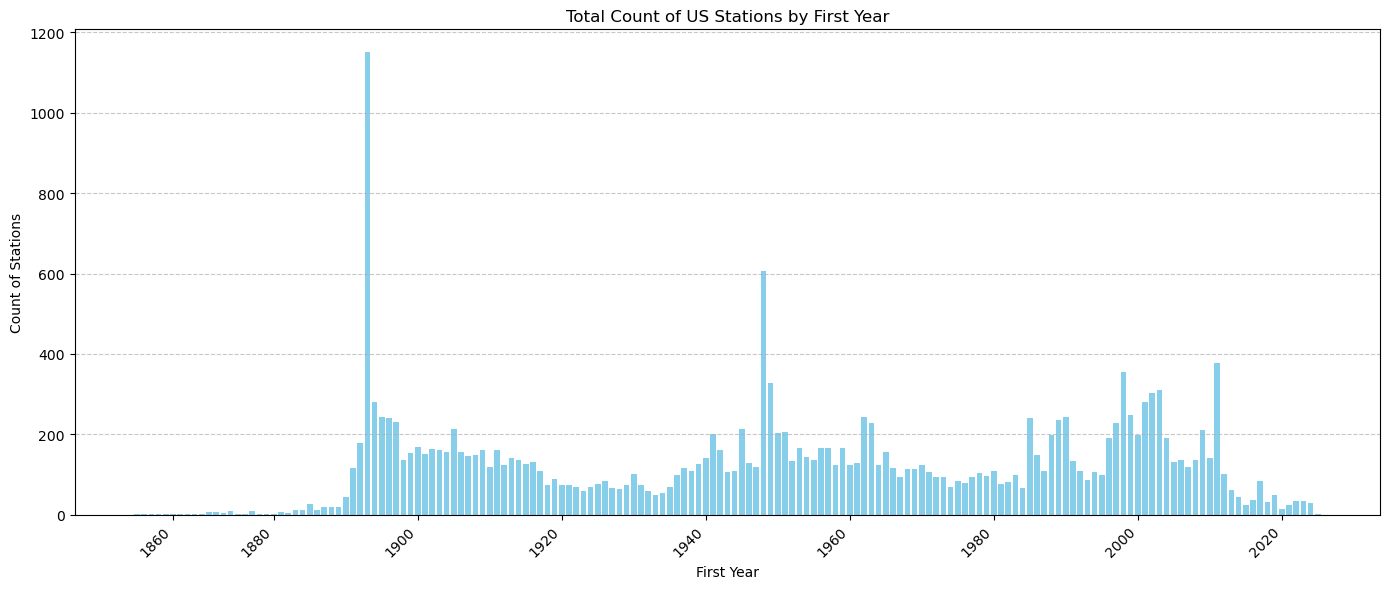

In [87]:
# Group by FIRSTYEAR and count the number of unique stations
firstyear_counts = us_inventory_df.groupby('FIRSTYEAR')['ID'].nunique()

# Sort by FIRSTYEAR for the plot
firstyear_counts = firstyear_counts.sort_index()

# Plot the results as a bar chart
plt.figure(figsize=(14, 6))
plt.bar(firstyear_counts.index.astype(str), firstyear_counts.values, color='skyblue')

# Set x-axis labels to show only every 20 years
years = firstyear_counts.index.astype(int)
min_year = min(years)
max_year = max(years)

# Create ticks every 20 years
tick_years = np.arange(min_year - (min_year % 20), max_year + 20, 20)
tick_labels = [str(year) for year in tick_years if year >= min_year and year <= max_year]
tick_positions = [str(year) for year in tick_years if year >= min_year and year <= max_year]

plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

plt.xlabel('First Year')
plt.ylabel('Count of Stations')
plt.title('Total Count of US Stations by First Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

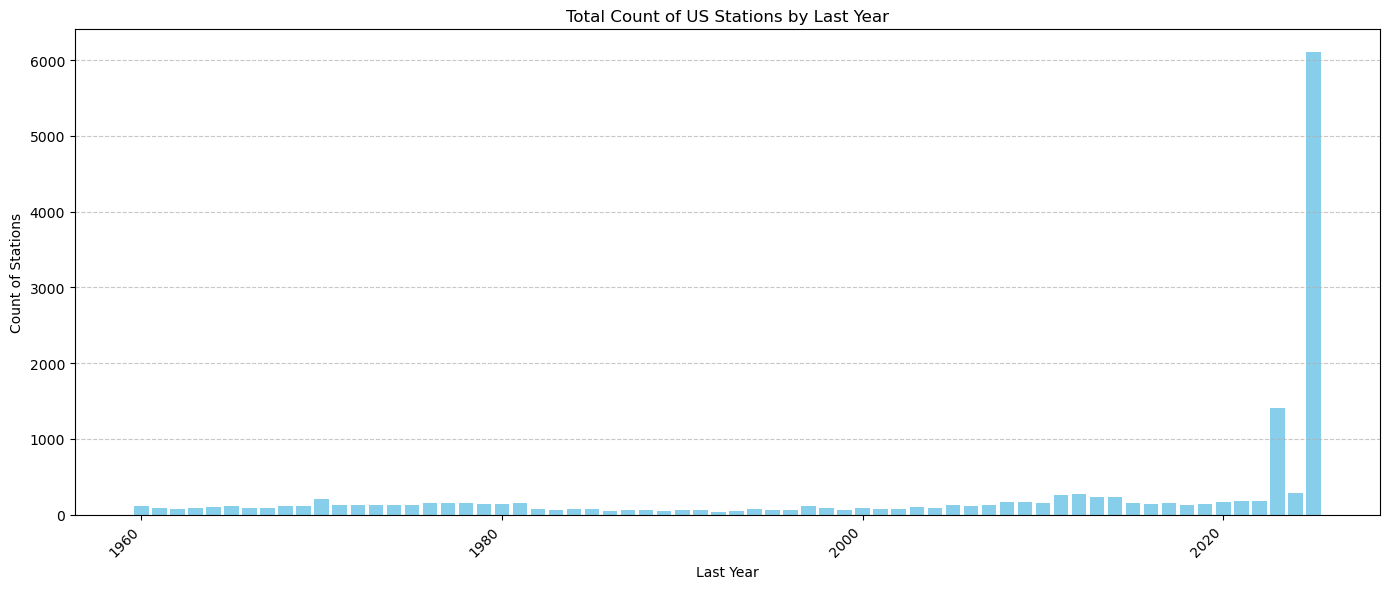

In [92]:
# Group by LASTYEAR and count the number of unique stations
lastyear_counts = us_inventory_df.groupby('LASTYEAR')['ID'].nunique()

# Sort by FIRSTYEAR for the plot
lastyear_counts = lastyear_counts.sort_index()

# Plot the results as a bar chart
plt.figure(figsize=(14, 6))
plt.bar(lastyear_counts.index.astype(str), lastyear_counts.values, color='skyblue')

# Set x-axis labels to show only every 20 years
years = lastyear_counts.index.astype(int)
min_year = min(years)
max_year = max(years)

# Create ticks every 20 years
tick_years = np.arange(min_year - (min_year % 20), max_year + 20, 20)
tick_labels = [str(year) for year in tick_years if year >= min_year and year <= max_year]
tick_positions = [str(year) for year in tick_years if year >= min_year and year <= max_year]

plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

plt.xlabel('Last Year')
plt.ylabel('Count of Stations')
plt.title('Total Count of US Stations by Last Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We will filter the US Stations looking for those that were active between 1960 and 2024, inclusive.

In [94]:
# Filter for stations active at any time between 1960 and 2024

# Start by converting FirstYear and LastYear to numeric values
us_inventory_df['FIRSTYEAR'] = pd.to_numeric(us_inventory_df['FIRSTYEAR'], errors='coerce')
us_inventory_df['LASTYEAR'] = pd.to_numeric(us_inventory_df['LASTYEAR'], errors='coerce')

# Filter condition: station is active sometime between 1960 and 2024 if its period overlaps with 1960-2024

overlap_condition = (us_inventory_df['FIRSTYEAR'] <= 2024) & (us_inventory_df['LASTYEAR'] >= 1960)

us_inventory_df = us_inventory_df[overlap_condition]

# Display the first few rows of the inventory data  
print(us_inventory_df.head())  

# Total number of Rows in Inventory
print("\nNumber of rows in us_inventory_df:", len(us_inventory_df))

                 ID  LATITUDE  LONGITUDE  FIRSTYEAR  LASTYEAR
181975  US009052008   43.7333   -96.6333       2008      2016
426107  USC00010063   34.2108   -87.1783       2001      2024
426147  USC00010148   34.2333   -86.1667       1908      1977
426165  USC00010160   32.9350   -85.9556       1969      2025
426175  USC00010163   32.9833   -85.8667       1942      1969

Number of rows in us_inventory_df: 15274


Let's view how many stations are active each year during the selected time frame (1960-2024).

Active Stations by Year:
    Year  ActiveStationCount
0   1960                6739
1   1961                6747
2   1962                6908
3   1963                7059
4   1964                7092
5   1965                7145
6   1966                7144
7   1967                7143
8   1968                7161
9   1969                7164
10  1970                7172
11  1971                7070
12  1972                7036
13  1973                7002
14  1974                6945
15  1975                6904
16  1976                6848
17  1977                6786
18  1978                6732
19  1979                6673


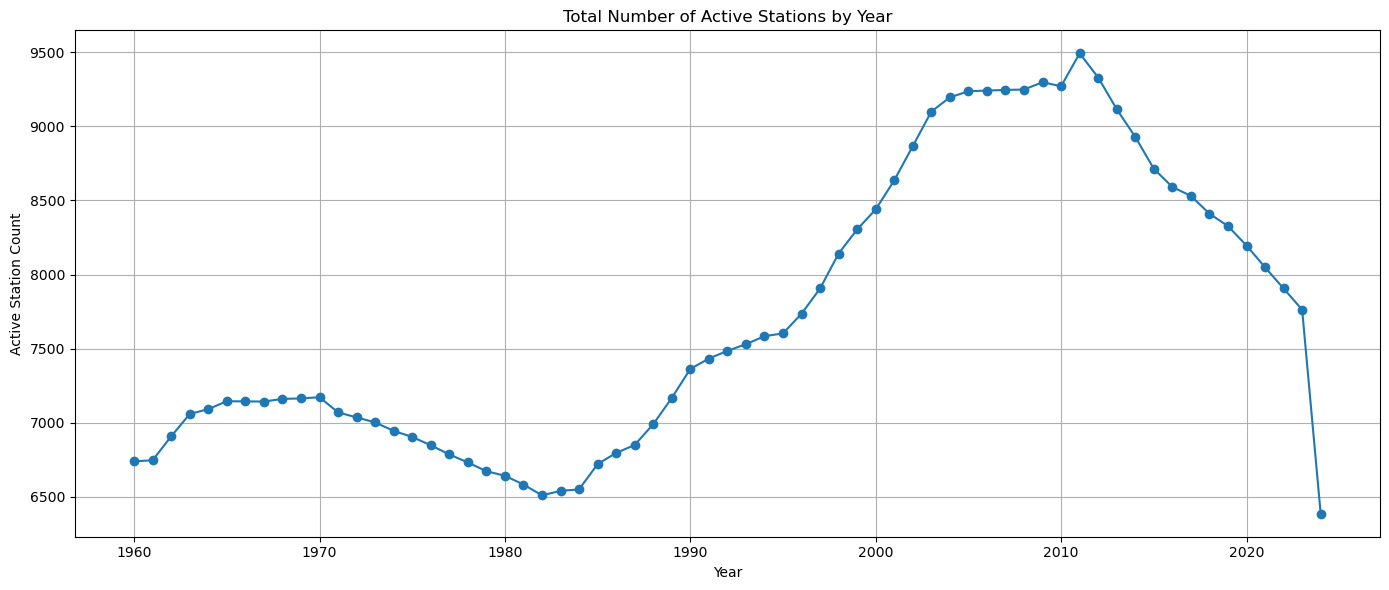

In [101]:
# Define the range of years based on the inventory  
min_year = 1960
max_year = 2024 
  
# Create a DataFrame to hold the count of active stations for each year  
years = np.arange(min_year, max_year + 1)  
active_counts = []  
  
# For each year, count the number of stations active  
for yr in years:  
    count = us_inventory_df[(us_inventory_df['FIRSTYEAR'] <= yr) & (us_inventory_df['LASTYEAR'] >= yr)].shape[0]  
    active_counts.append(count)  
  
active_df = pd.DataFrame({  
    'Year': years,  
    'ActiveStationCount': active_counts  
})  
  
print("Active Stations by Year:")  
print(active_df.head(20))  
  
# Optional: Plot the active station counts over time  
plt.figure(figsize=(14, 6))  
plt.plot(active_df['Year'], active_df['ActiveStationCount'], marker='o', linestyle='-')  
plt.xlabel('Year')  
plt.ylabel('Active Station Count')  
plt.title('Total Number of Active Stations by Year')  
plt.grid(True)  
plt.tight_layout()  
plt.show()  

#### Clean Stations Table

The **us_stations_df** will be cleaned to contain only the columns that are needed. The resultant table will be joined with the **us_inventory_df** to create a primary station table.

In [109]:
# Drop the specified columns
us_stations_df = us_stations_df.drop(columns=['LOCATION', 'GSN_FLAG', 'HCN_CRN_FLAG', 'WMO_ID'])

# Print the head of the dataframe for verification
print(us_stations_df.head())

                ID  LATITUDE  LONGITUDE  ELEVATION STATE
52997  US009052008   43.7333   -96.6333      482.0    SD
52998  US10RMHS145   40.5268  -105.1113     1569.1    CO
52999  US10ADAM001   40.5680   -98.5069      598.0    NE
53000  US10ADAM002   40.5093   -98.5493      601.1    NE
53001  US10ADAM003   40.4663   -98.6537      615.1    NE


#### Merge Inventory and Stations Table

The two tables will be joined by the Station ID to create a single data frame in which additional analysis and filtering will occur.

Since we have duplicate **LATITUDE** and **LONGITUDE** values in both tables, and we want to perform a data validation check on the values, we will rename the respective variables in **us_stations_df**.

In [118]:
# Rename columns in grouped_temp_stations to match temp_us_inventory_df for comparison
us_stations_df = us_stations_df.rename(columns={
    'LATITUDE': 'LATITUDE_STATIONS',
    'LONGITUDE': 'LONGITUDE_STATIONS'
})

# Print the head of the dataframe for verification
print(us_stations_df.head())

                ID  LATITUDE_STATIONS  LONGITUDE_STATIONS  ELEVATION STATE
52997  US009052008            43.7333            -96.6333      482.0    SD
52998  US10RMHS145            40.5268           -105.1113     1569.1    CO
52999  US10ADAM001            40.5680            -98.5069      598.0    NE
53000  US10ADAM002            40.5093            -98.5493      601.1    NE
53001  US10ADAM003            40.4663            -98.6537      615.1    NE


In [147]:
# Merge the two datasets on ID using a left join 
primary_stations_df = pd.merge(us_inventory_df, us_stations_df, on='ID', how='left')

# Print the head of the dataframe for verification
print(primary_stations_df.head())

            ID  LATITUDE  LONGITUDE  FIRSTYEAR  LASTYEAR  LATITUDE_STATIONS  \
0  US009052008   43.7333   -96.6333       2008      2016            43.7333   
1  USC00010063   34.2108   -87.1783       2001      2024            34.2108   
2  USC00010148   34.2333   -86.1667       1908      1977            34.2333   
3  USC00010160   32.9350   -85.9556       1969      2025            32.9350   
4  USC00010163   32.9833   -85.8667       1942      1969            32.9833   

   LONGITUDE_STATIONS  ELEVATION STATE  
0            -96.6333      482.0    SD  
1            -87.1783      239.6    AL  
2            -86.1667      348.1    AL  
3            -85.9556      201.2    AL  
4            -85.8667      200.9    AL  


#### Data Validation and Filtering on Primary Stations Table

Now that we have the primary table built, we will perform the following:
- Filter the table for the contiguous United States
- Evaluate the Latitude and Longitude values
- Check for Elevation measurement issues

#### Contiguous States Processing

In [149]:
# Define the state codes for the contiguous 48 states
contiguous_states = [
    'AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'ID', 
    'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 
    'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 
    'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 
    'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
]

# Check if STATE column has any NaN values
print(f"Number of stations with missing STATE values: {primary_stations_df['STATE'].isna().sum()}")

# Filter for stations in the contiguous 48 states
primary_stations_df = primary_stations_df[primary_stations_df['STATE'].isin(contiguous_states)]

# Total number of Rows in Primary Stations
print("\nNumber of rows in primary_stations_df:", len(primary_stations_df))

# Count stations by state
state_counts = primary_stations_df['STATE'].value_counts().sort_values(ascending=False)
print("\nNumber of stations by state (top 10):")
print(state_counts.head(10))

Number of stations with missing STATE values: 0

Number of rows in primary_stations_df: 14268

Number of stations by state (top 10):
STATE
CA    1077
TX     861
MT     612
CO     590
OR     587
UT     522
AZ     491
ID     424
WA     389
NY     380
Name: count, dtype: int64


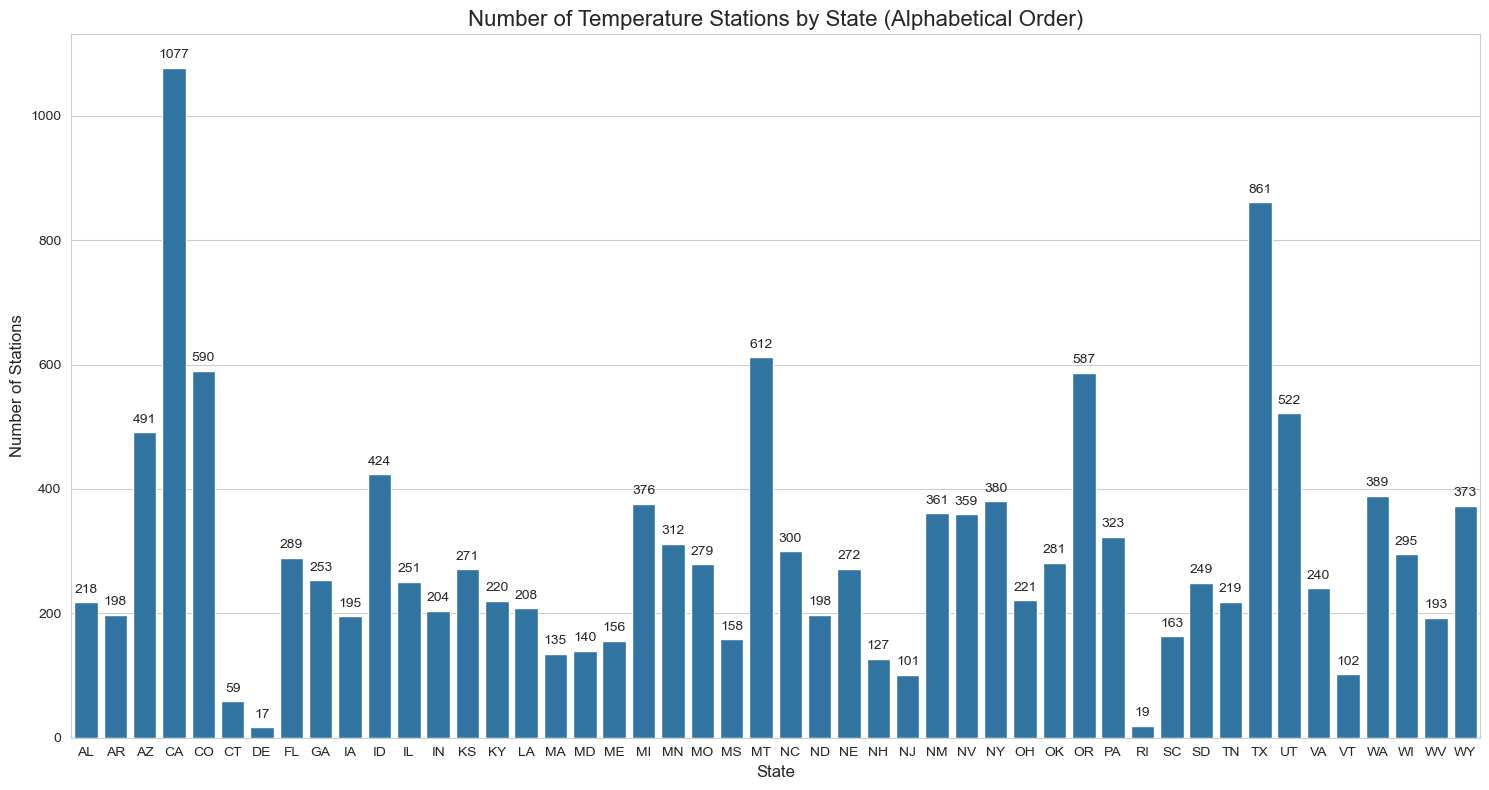

In [151]:
# Count the number of stations by state
state_counts = primary_stations_df.groupby('STATE').size().reset_index(name='COUNT')

# Sort the state counts alphabetically by state code
state_counts_alpha = state_counts.sort_values('STATE')

# Create the bar chart
plt.figure(figsize=(15, 8))
sns.set_style('whitegrid')

# Plot all states
ax = sns.barplot(x='STATE', y='COUNT', data=state_counts_alpha)
plt.title('Number of Temperature Stations by State (Alphabetical Order)', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Stations', fontsize=12)
plt.xticks(rotation=0)  # No rotation needed for state codes

# Add count labels on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

#### Latitude and Longitude Validation

In [153]:
# Determine whether Latitude and Longitude match for each stations

# Calculate the differences in coordinates
primary_stations_df['LAT_DIFF'] = abs(primary_stations_df['LATITUDE'] - primary_stations_df['LATITUDE_STATIONS'])
primary_stations_df['LON_DIFF'] = abs(primary_stations_df['LONGITUDE'] - primary_stations_df['LONGITUDE_STATIONS'])

# Check for exact matches
exact_matches = primary_stations_df[(primary_stations_df['LAT_DIFF'] == 0) & (primary_stations_df['LON_DIFF'] == 0)]

print(f"\nNumber of stations with exact coordinate matches: {len(exact_matches)}")
print(f"Percentage of exact matches: {len(exact_matches) / len(primary_stations_df) * 100:.2f}%")


Number of stations with exact coordinate matches: 14268
Percentage of exact matches: 100.00%


In [155]:
primary_stations_df.head()

,ID,LATITUDE,LONGITUDE,FIRSTYEAR,LASTYEAR,LATITUDE_STATIONS,LONGITUDE_STATIONS,ELEVATION,STATE,LAT_DIFF,LON_DIFF
0,US009052008,43.7333,-96.6333,2008,2016,43.7333,-96.6333,482.0,SD,0.0,0.0
1,USC00010063,34.2108,-87.1783,2001,2024,34.2108,-87.1783,239.6,AL,0.0,0.0
2,USC00010148,34.2333,-86.1667,1908,1977,34.2333,-86.1667,348.1,AL,0.0,0.0
3,USC00010160,32.9350,-85.9556,1969,2025,32.9350,-85.9556,201.2,AL,0.0,0.0
4,USC00010163,32.9833,-85.8667,1942,1969,32.9833,-85.8667,200.9,AL,0.0,0.0


In [157]:
#Drop the specified columns from the primary stations dataframe
primary_stations_df = primary_stations_df.drop(columns=['LATITUDE_STATIONS', 'LONGITUDE_STATIONS', 'LAT_DIFF', 'LON_DIFF'])

In [159]:
primary_stations_df.head()

,ID,LATITUDE,LONGITUDE,FIRSTYEAR,LASTYEAR,ELEVATION,STATE
0,US009052008,43.7333,-96.6333,2008,2016,482.0,SD
1,USC00010063,34.2108,-87.1783,2001,2024,239.6,AL
2,USC00010148,34.2333,-86.1667,1908,1977,348.1,AL
3,USC00010160,32.9350,-85.9556,1969,2025,201.2,AL
4,USC00010163,32.9833,-85.8667,1942,1969,200.9,AL


#### Elevation Validation

Some stations have default, -999.9, for their recorded Elevation. We will attempt to identify these defaults and replace them with actual evelation recordings. All elevations are in meters.

In [169]:
# Check for unusual patterns in Elevation - look at the distribution
print("\nBasic statistics for elevation:")
print(primary_stations_df[['ELEVATION']].describe())

# Check for default Elevation value
extreme_low_elev = primary_stations_df[primary_stations_df['ELEVATION'] == -999.9].shape[0]

print(f"\nStations with default elevation (= -999.9m): {extreme_low_elev}")


Basic statistics for elevation:
          ELEVATION
count  14268.000000
mean     729.795928
std      768.977373
min     -999.900000
25%      173.400000
50%      370.600000
75%     1219.200000
max     3800.900000

Stations with default elevation (= -999.9m): 18


#### Replace Default Elevation Values with Actual Values

We will use Open-Elevation API to replace elevation values using the Latitude and Longitude.

In [179]:
# Function to get elevation from Open-Elevation API for a list of (lat, lon) pairs

def get_elevations(coordinates):
    
    # Build the locations string for the GET request: format "lat,lon|lat,lon|..."
    locations_str = '|'.join([str(lat) + ',' + str(lon) for lat, lon in coordinates])
    
    url = 'https://api.open-elevation.com/api/v1/lookup'
    params = {'locations': locations_str}
    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        # The response should have a key 'results' with a list of dicts containing 'elevation'
        elevations = [result['elevation'] for result in data['results']]
        return elevations
    except Exception as e:
        print('Error during API call:', e)
        return [None] * len(coordinates)

In [181]:
# Find stations with default elevation value (-999.9)
mask_default = primary_stations_df['ELEVATION'] == -999.9
stations_default_elev = primary_stations_df[mask_default]

print(f"Found {len(stations_default_elev)} stations with a default elevation of -999.9")

Found 18 stations with a default elevation of -999.9


In [185]:
# If there are no stations, skip
if len(stations_default_elev) > 0:
    # We'll update in batches of 20 stations to reduce the number of API queries
    batch_size = 20
    indices_to_update = stations_default_elev.index.tolist()
    for i in tqdm(range(0, len(indices_to_update), batch_size), desc='Updating elevations'):
        batch_indices = indices_to_update[i:i+batch_size]
        # Get their latitudes and longitudes
        coords = list(zip(primary_stations_df.loc[batch_indices, 'LATITUDE'], 
                          primary_stations_df.loc[batch_indices, 'LONGITUDE']))
        # Query the elevation API 
        new_elevs = get_elevations(coords)
        # Update the dataframe
        for idx, elev in zip(batch_indices, new_elevs):
            if elev is not None:
                primary_stations_df.at[idx, 'ELEVATION'] = elev
            else:
                print(f"Could not update elevation for index {idx}")

    # Final check of default values left
    remaining_defaults = (primary_stations_df['ELEVATION'] == -999.9).sum()
    print(f"\nRemaining stations with default elevation: {remaining_defaults}")
else:
    print("\nNo stations with default elevation to update.")

print("\nElevation update complete.")

Updating elevations: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Remaining stations with default elevation: 0

Elevation update complete.


In [187]:
# Verify results of Open-Elevation API
extreme_low_elev = primary_stations_df[primary_stations_df['ELEVATION'] == -999.9].shape[0]

print(f"\nStations with default elevation (= -999.9m): {extreme_low_elev}")


Stations with default elevation (= -999.9m): 0


In [189]:
primary_stations_df.head()

,ID,LATITUDE,LONGITUDE,FIRSTYEAR,LASTYEAR,ELEVATION,STATE
0,US009052008,43.7333,-96.6333,2008,2016,482.0,SD
1,USC00010063,34.2108,-87.1783,2001,2024,239.6,AL
2,USC00010148,34.2333,-86.1667,1908,1977,348.1,AL
3,USC00010160,32.9350,-85.9556,1969,2025,201.2,AL
4,USC00010163,32.9833,-85.8667,1942,1969,200.9,AL


### Summary of Station Processing

The new table, **primary_stations_df**, now consists of GHCN stations that are located in the contiguous United States, are designated as collecting temperature observations, have been validated for their geopositioning, have been updated to contain accurate elevation readings, and were active during the period in which we wish to gather actual temperature observations between 1960 and 2024, inclusive.

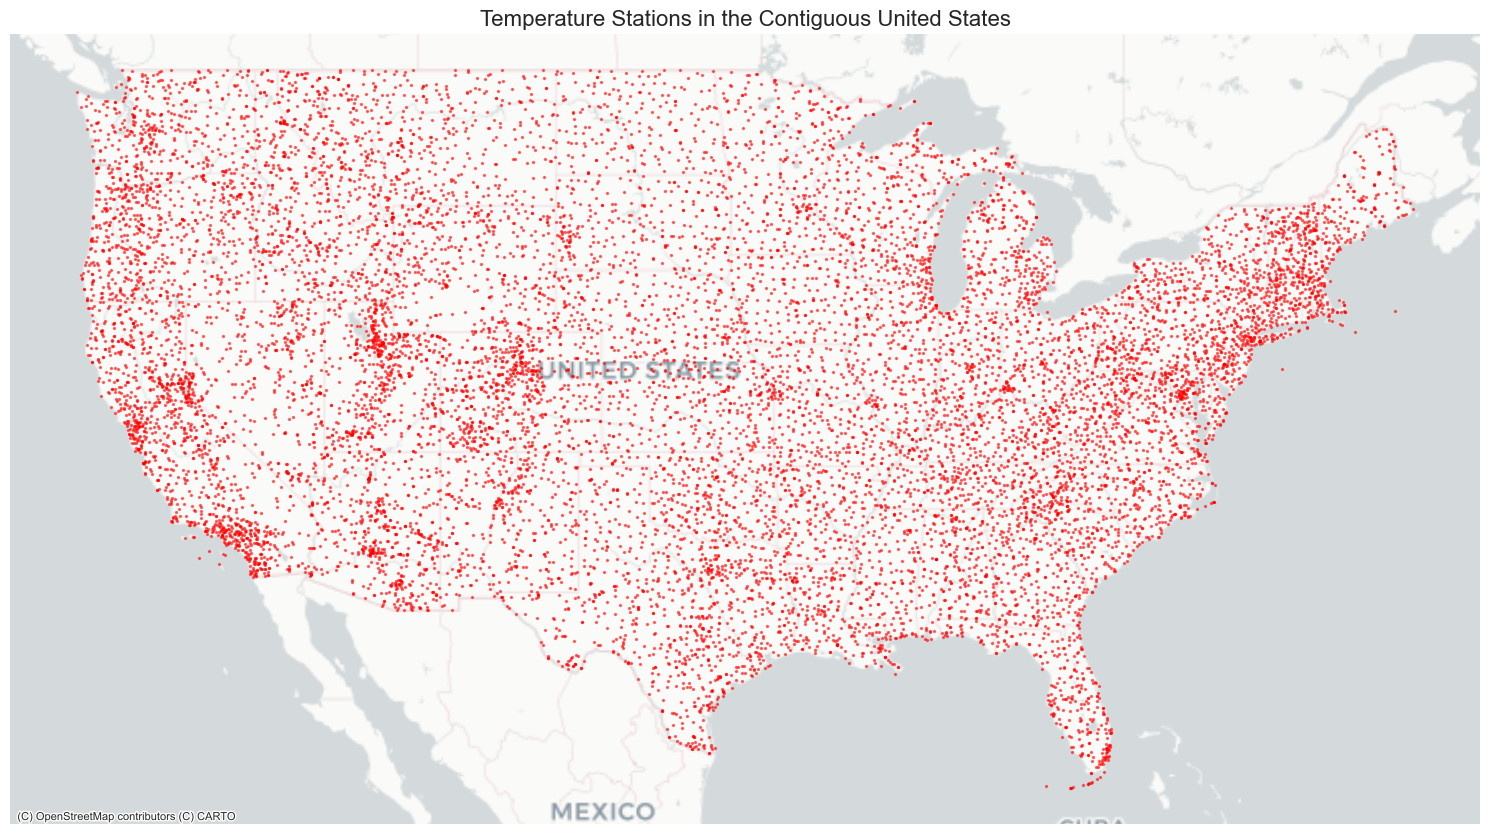

In [200]:
# Create a GeoDataFrame with Point geometry for each station  
geometry = [Point(xy) for xy in zip(primary_stations_df['LONGITUDE'], primary_stations_df['LATITUDE'])]  
gdf = gpd.GeoDataFrame(primary_stations_df, geometry=geometry)  
  
# Set the initial coordinate reference system to WGS84 (latitude/longitude)  
gdf.crs = "EPSG:4326"  
  
# Convert to Web Mercator for compatibility with the basemap  
gdf = gdf.to_crs(epsg=3857)  
  
# Create the plot  
fig, ax = plt.subplots(figsize=(15, 10))  
gdf.plot(ax=ax, markersize=2, color='red', alpha=0.5)  
  
# Add a basemap from contextily  
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)  
  
# Set plot title and turn off axis  
plt.title('Temperature Stations in the Contiguous United States', fontsize=16)  
ax.set_axis_off()  
  
plt.tight_layout()  
plt.show()  

### GHCN Daily Weather Data Acquisition

For the purposes of testing the data acquisition and pre-processing requirements, we will load the daily data for the year 2024. This will establish the data processing rules for the entire project requiring data from 1960 through 2024.

#### GHCN Daily Download for 2024

In [223]:
# URL for the 2024 data  
url_2024 = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_year/2024.csv.gz"  
  
# Download the file  
print("Downloading 2024 data...")  
response = requests.get(url_2024)  
if response.status_code == 200:  
    print("Download complete.")  
else:  
    print("Error downloading file: ", response.status_code)  
    raise Exception("Download failed with status code " + str(response.status_code))  
  
# Read the CSV data from the downloaded gzip content into a pandas DataFrame  
print("Processing data for 2024...")  
data_2024 = pd.read_csv(io.BytesIO(response.content), compression='gzip', header=None)  
  
# Assign column names  
data_2024.columns = ['ID','DATE','ELEMENT','DATA_VALUE','M_FLAG','Q_FLAG','S_FLAG','OBS_TIME']

# Display the first few rows data
print(data_2024.head())  

Download complete.
Processing data for 2024...
            ID      DATE ELEMENT  DATA_VALUE M_FLAG Q_FLAG S_FLAG  OBS_TIME
0  AE000041196  20240101    TMAX         278    NaN    NaN      S       NaN
1  AE000041196  20240101    TMIN         182    NaN    NaN      S       NaN
2  AE000041196  20240101    PRCP           0      D    NaN      S       NaN
3  AE000041196  20240101    TAVG         236      H    NaN      S       NaN
4  AEM00041194  20240101    TMAX         277    NaN    NaN      S       NaN


#### Filter for Stations in the US

In [225]:
# Filter for US stations only (where ID starts with 'US')
data_2024 = data_2024[data_2024['ID'].str.startswith(us_code)]
  
# Display the first few rows of the daily data  
print(data_2024.head())

# Total number of Rows in 2024 Data
print("\nNumber of rows in data_2024:", len(data_2024))

                ID      DATE ELEMENT  DATA_VALUE M_FLAG Q_FLAG S_FLAG  \
15838  US1FLCR0065  20240101    PRCP           0    NaN    NaN      N   
15839  US1FLCR0065  20240101    SNOW           0    NaN    NaN      N   
15840  US1FLCR0067  20240101    PRCP           5    NaN    NaN      N   
15841  US1FLCR0071  20240101    PRCP           0    NaN    NaN      N   
15842  US1FLCR0071  20240101    SNOW           0    NaN    NaN      N   

       OBS_TIME  
15838     801.0  
15839     801.0  
15840     800.0  
15841     700.0  
15842     700.0  

Number of rows in data_2024: 28307326


#### Filter for Temperature Observations

In [227]:
# Filter for temperature elements (TMAX, TMIN, TAVG)  
data_2024 = data_2024[data_2024['ELEMENT'].isin(elements_of_interest)]  

# Display the first few rows of the daily data  
print(data_2024.head())

# Total number of Rows in 2024 Data
print(f"Number of temperature records from US stations: {len(data_2024)}")  

                ID      DATE ELEMENT  DATA_VALUE M_FLAG Q_FLAG S_FLAG  \
18576  USW00096406  20240101    TMAX        -127    NaN    NaN      R   
18577  USW00096406  20240101    TMIN        -251    NaN    NaN      R   
18579  USW00096407  20240101    TMAX        -103    NaN    NaN      R   
18580  USW00096407  20240101    TMIN        -146    NaN    NaN      R   
18582  USW00096408  20240101    TMAX         -64    NaN    NaN      W   

       OBS_TIME  
18576       NaN  
18577       NaN  
18579       NaN  
18580       NaN  
18582       NaN  
Number of temperature records from US stations: 6080056


#### Drop the Unneeded Columns

In [229]:
# Drop the unnecessary columns  
data_2024 = data_2024.drop(columns=['M_FLAG', 'Q_FLAG', 'S_FLAG', 'OBS_TIME'])   
  
# Display the first few rows of the data  
print("\nFirst few rows of data:")  
print(data_2024.head())  


First few rows of data:
                ID      DATE ELEMENT  DATA_VALUE
18576  USW00096406  20240101    TMAX        -127
18577  USW00096406  20240101    TMIN        -251
18579  USW00096407  20240101    TMAX        -103
18580  USW00096407  20240101    TMIN        -146
18582  USW00096408  20240101    TMAX         -64


#### Generate Basic Statistics by Element Type

In [240]:
# Display total count of observations
print("\nTotal number of records:")  
print(len(data_2024))  

# Display counts by element type  
element_counts = data_2024['ELEMENT'].value_counts()

print("\nCounts by element type:")  
print(element_counts)  
  
# Calculate basic statistics for each element type  
print("\nBasic statistics for each element type:")  

for element in elements_of_interest:  
    element_data = data_2024[data_2024['ELEMENT'] == element]  
    if len(element_data) > 0:
        
        # Convert data values from tenths of degrees C to degrees C  
        values_in_c = element_data['DATA_VALUE'] / 10.0  
        print(f"\n{element} statistics (in degrees C):")  
        print(f"Count: {len(element_data)}")  
        print(f"Mean: {values_in_c.mean():.2f}°C")  
        print(f"Min: {values_in_c.min():.2f}°C")  
        print(f"Max: {values_in_c.max():.2f}°C")  


Total number of records:
6080056

Counts by element type:
ELEMENT
TMAX    2619256
TMIN    2615793
TAVG     845007
Name: count, dtype: int64

Basic statistics for each element type:

TMAX statistics (in degrees C):
Count: 2619256
Mean: 17.99°C
Min: -60.60°C
Max: 807.80°C

TMIN statistics (in degrees C):
Count: 2615793
Mean: 5.57°C
Min: -241.70°C
Max: 220.00°C

TAVG statistics (in degrees C):
Count: 845007
Mean: 9.12°C
Min: -99.90°C
Max: 119.60°C


#### Transform the Table

Given that some records contain maximum and minimum temperature records, and some contain the daily average, we have chosen to use the daily average temperature as the basis for analysis. This will require transforming the table and then performing a calculation to generate **TAVG** where the value doesn't exist.

In [302]:
# Pivot the DataFrame so that we have one row per (ID, DATE)  
# and separate columns for each ELEMENT using DATA_VALUE as the value.  
pivot_2024_df = data_2024.pivot_table(  
    index=['ID', 'DATE'],  
    columns='ELEMENT',  
    values='DATA_VALUE',  
    aggfunc='first'   # assuming only one VALUE per (ID, DATE, ELEMENT)  
).reset_index()  
  
# Remove any hierarchical column names (flatten the DataFrame's columns)  
pivot_2024_df.columns.name = None  
  
# Show the shape and first few rows of the resulting DataFrame  
print("Pivoted dataset shape: " + str(pivot_2024_df.shape))  
print("\nFirst few rows of the pivoted dataset:")  
print(pivot_2024_df.head())  

Pivoted dataset shape: (2624611, 5)

First few rows of the pivoted dataset:
            ID      DATE  TAVG   TMAX  TMIN
0  USC00010063  20240101   NaN  150.0 -39.0
1  USC00010063  20240102   NaN   56.0 -33.0
2  USC00010063  20240103   NaN   94.0 -50.0
3  USC00010063  20240104   NaN   50.0 -56.0
4  USC00010063  20240105   NaN   44.0 -61.0


#### Explore Elements before Calculations

In [304]:
# Check how many  values we have in TAVG column  
print("Number of  values in TAVG before filling: " + str(pivot_2024_df['TAVG'].isna().sum()))  
  
# Calculate the number of rows with TMAX and TMIN but no TAVG  
rows_with_tmax_tmin_no_tavg = pivot_2024_df[(pivot_2024_df['TMAX'].notna()) &   
                                            (pivot_2024_df['TMIN'].notna()) &   
                                            (pivot_2024_df['TAVG'].isna())].shape[0]  

print("Number of rows with TMAX and TMIN but no TAVG: " + str(rows_with_tmax_tmin_no_tavg))

Number of  values in TAVG before filling: 1779604
Number of rows with TMAX and TMIN but no TAVG: 1767187


#### Perform Calculations for TAVG

All temperature values are in tenths of degrees Celsius

In [306]:
# Calculate TAVG as the average of TMAX and TMIN only when TAVG is NA
pivot_2024_df['TAVG'] = pivot_2024_df['TAVG'].fillna((pivot_2024_df['TMAX'] + pivot_2024_df['TMIN']) / 2)  
  
# Check how many  values remain in TAVG column  
print("Number of values in TAVG after filling: " + str(pivot_2024_df['TAVG'].isna().sum()))

Number of values in TAVG after filling: 12417


In [308]:
# Calculate some statistics to verify changes  
print("\nStatistics for temperature columns (in tenths of degrees C):")  
print(pivot_2024_df[['TMAX', 'TMIN', 'TAVG']].describe()) 


Statistics for temperature columns (in tenths of degrees C):
               TMAX          TMIN          TAVG
count  2.619256e+06  2.615793e+06  2.612194e+06
mean   1.798711e+02  5.566998e+01  1.167827e+02
std    1.180634e+02  1.049272e+02  1.084551e+02
min   -6.060000e+02 -2.417000e+03 -9.990000e+02
25%    9.400000e+01 -1.700000e+01  3.850000e+01
50%    1.940000e+02  5.600000e+01  1.250000e+02
75%    2.720000e+02  1.330000e+02  2.030000e+02
max    8.078000e+03  2.200000e+03  2.500000e+03


In [310]:
print(pivot_2024_df.head())  

            ID      DATE  TAVG   TMAX  TMIN
0  USC00010063  20240101  55.5  150.0 -39.0
1  USC00010063  20240102  11.5   56.0 -33.0
2  USC00010063  20240103  22.0   94.0 -50.0
3  USC00010063  20240104  -3.0   50.0 -56.0
4  USC00010063  20240105  -8.5   44.0 -61.0


We no longer need the **TMAX** and **TMIN** columns so we can drop them from the table.

In [312]:
# Drop TMAX and TMIN columns  
pivot_2024_df = pivot_2024_df.drop(columns=['TMAX', 'TMIN'])  
  
# Display the shape after dropping columns  
print("Dataset shape after dropping columns: " + str(pivot_2024_df.shape))  
  
# Display the first few rows of the simplified DataFrame  
print("\nFirst few rows of the simplified dataset:")  
print(pivot_2024_df.head()) 

Dataset shape after dropping columns: (2624611, 3)

First few rows of the simplified dataset:
            ID      DATE  TAVG
0  USC00010063  20240101  55.5
1  USC00010063  20240102  11.5
2  USC00010063  20240103  22.0
3  USC00010063  20240104  -3.0
4  USC00010063  20240105  -8.5


#### Generate Statistics

2024 was a leap year so it contained 366 days. We want to determine the level of completeness for the dataset. At a high level, we want to know the number of unique stations, the number of unique dates, and the total number of observations recorded. This will give us an indication, at the dataset level, of the completeness of the data.

In [314]:
# Count the number of unique stations  
unique_stations = pivot_2024_df['ID'].nunique()  
print("\nNumber of unique stations: " + str(unique_stations))  
  
# Count the number of unique dates  
unique_dates = pivot_2024_df['DATE'].nunique()  
print("Number of unique dates: " + str(unique_dates))  
  
# Calculate the theoretical maximum number of rows if all stations had data for all dates  
theoretical_max = unique_stations * unique_dates  

print("Theoretical maximum number of rows: " + str(theoretical_max))  
print("Data completeness: {:.2f}%".format(pivot_2024_df.shape[0] / theoretical_max * 100))  


Number of unique stations: 7602
Number of unique dates: 366
Theoretical maximum number of rows: 2782332
Data completeness: 94.33%


#### Check for Completeness

Based on a completeness percentage less than 100%, let's look at each station to determine its completeness perecentage.

In [316]:
# Expected number of observations per station is 366.  
completeness_df = pivot_2024_df.groupby('ID').agg(  
    Observations=('TAVG', 'count')  
).reset_index()  
  
# Add expected observations column and completeness percentage  
completeness_df['Expected'] = 366  
completeness_df['Completeness (%)'] = (completeness_df['Observations'] / completeness_df['Expected']) * 100  
  
print("Data Completeness Table:")  
print(completeness_df.head(20))  

# Distribution of observations  
print("\nDistribution of observations across all stations:")  
print(completeness_df['Observations'].describe()) 

Data Completeness Table:
             ID  Observations  Expected  Completeness (%)
0   USC00010063           307       366         83.879781
1   USC00010160           365       366         99.726776
2   USC00010178           297       366         81.147541
3   USC00010260           365       366         99.726776
4   USC00010370           356       366         97.267760
5   USC00010390           363       366         99.180328
6   USC00010402           366       366        100.000000
7   USC00010425           366       366        100.000000
8   USC00010505           345       366         94.262295
9   USC00010583           366       366        100.000000
10  USC00010655           365       366         99.726776
11  USC00010764           360       366         98.360656
12  USC00011080           364       366         99.453552
13  USC00011490           366       366        100.000000
14  USC00011620           347       366         94.808743
15  USC00011694           321       366        

In [318]:
# Calculate the number of stations with 100% completeness  
total_stations = completeness_df.shape[0]  
full_completeness_stations = completeness_df[completeness_df['Observations'] == 366].shape[0]  
  
percentage_full = (full_completeness_stations / total_stations) * 100  
  
print("Total stations:", total_stations)  
print("Stations with 100% completeness:", full_completeness_stations)  
print("Percentage of stations that are 100% complete: {:.2f}%".format(percentage_full))  

Total stations: 7602
Stations with 100% completeness: 3442
Percentage of stations that are 100% complete: 45.28%


#### Alternate Check for Completeness Based on >= 4 Observations per Week

We may need to adjust the data to look at weekly average temperature instead of daily. The next option would be to fill in missing data using imputation.

In [322]:
print(pivot_2024_df.head())

            ID      DATE  TAVG
0  USC00010063  20240101  55.5
1  USC00010063  20240102  11.5
2  USC00010063  20240103  22.0
3  USC00010063  20240104  -3.0
4  USC00010063  20240105  -8.5


In [324]:
temp_df = pivot_2024_df.copy()

# Convert DATE column using the specified format  
temp_df['DATE'] = pd.to_datetime(temp_df['DATE'].astype(str), format='%Y%m%d')  
  
# Create the week column using ISO week number  
temp_df['WEEK'] = temp_df['DATE'].dt.isocalendar().week  
  
print("Corrected DATE and Week values sample:")  
print(temp_df[['ID', 'DATE', 'WEEK']].head(20))  

Corrected DATE and Week values sample:
             ID       DATE  WEEK
0   USC00010063 2024-01-01     1
1   USC00010063 2024-01-02     1
2   USC00010063 2024-01-03     1
3   USC00010063 2024-01-04     1
4   USC00010063 2024-01-05     1
5   USC00010063 2024-01-06     1
6   USC00010063 2024-01-07     1
7   USC00010063 2024-01-08     2
8   USC00010063 2024-01-09     2
9   USC00010063 2024-01-10     2
10  USC00010063 2024-01-11     2
11  USC00010063 2024-01-12     2
12  USC00010063 2024-01-13     2
13  USC00010063 2024-01-14     2
14  USC00010063 2024-01-15     3
15  USC00010063 2024-01-16     3
16  USC00010063 2024-01-17     3
17  USC00010063 2024-01-18     3
18  USC00010063 2024-01-19     3
19  USC00010063 2024-01-20     3


In [328]:
# Group by station ID and week, count observations  
weekly_counts = temp_df.groupby(['ID', 'WEEK']).size().reset_index(name='Observations') 

print(weekly_counts.head())

            ID  WEEK  Observations
0  USC00010063     1             7
1  USC00010063     2             7
2  USC00010063     3             7
3  USC00010063     4             7
4  USC00010063     5             7


In [334]:
# For each station, compute the minimum number of observations across all weeks.  
min_weekly_obs = weekly_counts.groupby('ID')['Observations'].min().reset_index()  
min_weekly_obs.rename(columns={'Observations': 'Min_Weekly_Observations'}, inplace=True)  
  
# Identify stations that have at least 4 observations in every week.  
stations_with_requirement = min_weekly_obs[min_weekly_obs['Min_Weekly_Observations'] >= 4]  
  
# Calculate summary count and percentage.  
total_stations = min_weekly_obs.shape[0]  
count_stations_meeting_req = stations_with_requirement.shape[0]  
percentage_stations = (count_stations_meeting_req / total_stations) * 100  
  
print("Total unique stations:", total_stations)  
print("Stations with at least 4 observations for every week:", count_stations_meeting_req)  
print("Percentage of stations meeting the requirement: {:.2f}%".format(percentage_stations))  

Total unique stations: 7602
Stations with at least 4 observations for every week: 6082
Percentage of stations meeting the requirement: 80.01%


This means that approximately 80% of all weather stations in the 2024 dataset have at least 4 observations recorded for every week of the year.

This can occur when there are maintenance periods, equipment failures, outages, or station decommissioning that occurs during the year.

##### Histogram of Observations Per Week

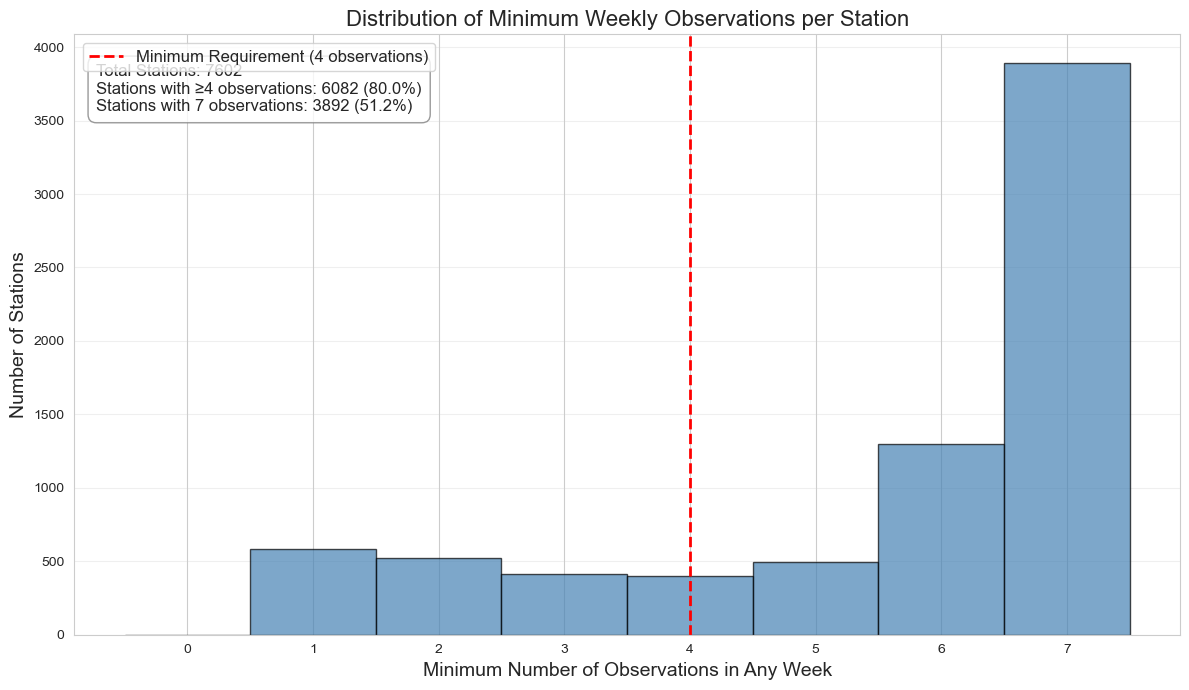

In [337]:
# Create a histogram of the minimum weekly observations  
plt.figure(figsize=(12, 7))  
  
# Create the histogram with custom bins (0 to 7)  
bins = np.arange(0, 8.5, 1) - 0.5  # Creates bins centered at 0, 1, 2, ..., 7  
plt.hist(min_weekly_obs['Min_Weekly_Observations'], bins=bins,   
         edgecolor='black', alpha=0.7, color='steelblue')  
  
# Add vertical line at x=4 (our threshold)  
plt.axvline(x=4, color='red', linestyle='--', linewidth=2,   
            label='Minimum Requirement (4 observations)')  
  
# Add labels and title  
plt.title('Distribution of Minimum Weekly Observations per Station', fontsize=16)  
plt.xlabel('Minimum Number of Observations in Any Week', fontsize=14)  
plt.ylabel('Number of Stations', fontsize=14)  
  
# Set x-ticks to be at whole numbers  
plt.xticks(range(0, 8))  
  
# Add grid for better readability  
plt.grid(axis='y', alpha=0.3)  
  
# Add text annotation with summary statistics  
stats_text = f"Total Stations: {len(min_weekly_obs)}\n"  
stats_text += f"Stations with ≥4 observations: {len(min_weekly_obs[min_weekly_obs['Min_Weekly_Observations'] >= 4])} ({80.01:.1f}%)\n"  
stats_text += f"Stations with 7 observations: {len(min_weekly_obs[min_weekly_obs['Min_Weekly_Observations'] == 7])} ({len(min_weekly_obs[min_weekly_obs['Min_Weekly_Observations'] == 7])/len(min_weekly_obs)*100:.1f}%)"  
  
plt.annotate(stats_text, xy=(0.02, 0.95), xycoords='axes fraction',   
             bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),  
             fontsize=12, va='top')  
  
# Add legend  
plt.legend(fontsize=12)  
  
plt.tight_layout()  
plt.show()  

## Recommended Approach for Next Steps in Data Pre-Processing for Model Development

When creating a dataset for modeling expected temperature based on geographic factors and historical data from 1960-2024, we are faced with a classic data quality vs. quantity tradeoff. Based on the analysis, we have a 94.33% completion level for daily temperature observations and only 80% of stations that have 4 or more observations in each week.

The recommendation in creating a pre-processing strategy for model usage is the following:

1. **Create Multiple Dataset Tiers**
   - **Tier 1: High-Quality Dataset (Primary)**
       - Include only stations with ≥4 observations per week consistently
       - No imputation for these stations (or minimal imputation if needed)
       - Use this as the primary training dataset
   - **Tier 2: Medium-Quality Dataset (Supplementary)**
       - Include stations with 2-3 observations per week minimum
       - Apply careful imputation methods
       - Use this to supplement spatial coverage where Tier 1 is sparse
   - **Tier 3: Complete Spatial Coverage (Validation)**
       - Include all stations with at least 1 observation per week
       - More aggressive imputation
       - Use primarily for validation and to ensure no spatial blind spots
    
2. **Imputation Strategies For Missing Daily Values**
   - **Temporal Interpolation**
       - For isolated missing days, interpolate from surrounding days at the same station
   - **Spatial Interpolation**
       - Use nearby stations' data weighted by distance
   - **Climatological Replacement**
       - Use historical averages for that station/date
    
**Rationale for Strategy**
1. **Preserves Data Quality:** The primary analysis uses the most reliable data
2. **Maximizes Coverage:** We don't discard potentially valuable stations
3. **Quantifies Uncertainty:** By comparing across tiers, we can assess the impact of data quality
4. **Flexible Implementation:** Thresholds can be adjusted based on spatial coverage needs